## Inverse Transform Sampling Via Generative Adversarial Networks

**What is Inverse Transform Sampling?**

[Inverse transform sampling](https://en.wikipedia.org/wiki/Inverse_transform_sampling) (ITS) is a generic technique used for generating independent sample numbers at random given any underlying probability distribution. It is akin to other random number generation techniques such as [rejection sampling](https://en.wikipedia.org/wiki/Rejection_sampling), [Ziggurat algorithm](https://en.wikipedia.org/wiki/Ziggurat_algorithm) and [Box-Muller transform](https://en.wikipedia.org/wiki/Box%E2%80%93Muller_transform). It operates as follows:
suppose we wish to generate samples from a continuous probability distribution with cumulative density function (CDF) $F_X(x)$. ITS takes a uniform sample of a random variable $U$ that is disributed between $[0,1]$, interprets it as a probability, and generates sample $x$ for which $F_X(x) = u$, i.e., $x = F^{-1}_X(u)$.

As an illustration, consider the case when we wish to generate samples from an exponential distribution, i.e., $F_X(x)=(1-e^{-\lambda x})$ for $x\geq 0$ and $0$ otherwise. Using ITS, we obtain $F_X(x) = u$, or equivalently, $x=-\frac{1}{\lambda}\ln(1-u)$. The mapping between $u$ and $x$ is indicated in the following graph.

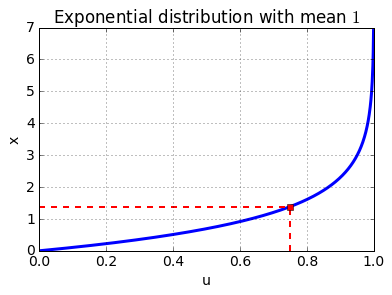

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from pylab import rcParams
rcParams.update({'font.size': 14})

l = 1 # lambda
u_range = np.arange(0,1,0.001)
x = [-1/l*np.log(1-u) for u in u_range]

plt.plot(u_range,x,linewidth=3)
plt.grid()
plt.xlabel('u');plt.ylabel('x')
plt.title('Exponential distribution with mean $1$')

# Sample value of u
u = 0.75
plt.plot([u,u],[0,-1/l*np.log(1-u)],'r--',linewidth=2)
plt.plot([0,u],[-1/l*np.log(1-u),-1/l*np.log(1-u)],'r--',linewidth=2)
plt.plot(u,-1/l*np.log(1-u),'rs')

In the above depiction, each of the randomly generated numbers from a uniform distribution are mapped to a sample $x$. For instance, when $\lambda=1$, $u=0.75$ is mapped to $x\approx1.38$ (marked by the red dashed lines).

Conceptually, the ITS method makes sense since the CDF of any random variable lies between $0$ and $1$, and samples $x$ are generated according to their contribution towards the CDF. This approach also extends to discrete distributions, if we simply generate the largest sample $x$ from the domain of the distribution such that $F_X(x)\leq u$.

The above method will, however, not work in several cases such as:
- Unknown distribution (when the distribution of the random variable is not known in tractable form)
- Diverging or analytically intractable CDF, e.g. [Hyperbolic distribution](https://en.wikipedia.org/wiki/Hyperbolic_distribution)
- Non-invertible or analytically intractable CDF, e.g., [Gaussian distribution](https://en.wikipedia.org/wiki/Normal_distribution), [Cauchy distribution](https://en.wikipedia.org/wiki/Cauchy_distribution)
- Mixture of densities, e.g., [Mixture Distribution](https://en.wikipedia.org/wiki/Mixture_distribution)
- Functions or transformations of random variables, e.g. for generating square of a Gaussian distribution
- Multi-dimensional random variables, e.g., [Multivariate Gaussian distribution](https://en.wikipedia.org/wiki/Multivariate_normal_distribution)

Moreover, in order to obtain a large number of samples, one needs to perform the CDF inversion multiple times, which is expensive. One possible way to reduce the number of inversions to only a few while obtaining a large number of samples is the application of the so-called the [*Stochastic Collocation Monte Carlo* (SCMC) sampler](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2529691). However, SCMS methods are computationally expensive as they use the squared Bessel process.

> An immediate follow-up question becomes "Are there other methods using which we can generate independent random numbers with a lower computation overhead? Say hello to GANs.

**What are GANs?**

Generative Adversarial Networks (GANs) are examples of generative models in the machine learning literature. They are used in the context of unsupervised or semi-supervised learning. Using a few training data samples, GANs learn to represent an estimate of the distribution. For a detailed introduction to GANs, please refer to the seminal paper by Goodfellow et al. [[1]](https://arxiv.org/abs/1406.2661) or the same author's excellent summary on GANs at NIPS 2016 [[2]](https://arxiv.org/abs/1701.00160).

GANs essentially comprise two deep neural networks, the **Discriminator** and the **Generator**. The discriminator function $D$ takes in an input sample $x$ and determines the probability $D(x)$, of $x$ having been drawn from the original data distribution. The generator function $G$ takes in a noisy sample $z$, and generates a sample $G(z)$, that is intended to fool the discriminator into believing that the sample is indeed from the original data distribution. While the generator attempts to generate samples that are probabilistically close to the training data, the discriminator attempts to deem the generated samples as fake, i.e., not having been drawn from the true distribution. A conceptual illustration of a GAN generating a MNIST digit sample is provided below (Picture credit [[3]](https://www.slideshare.net/ckmarkohchang/generative-adversarial-networks)).
![GANs concept]({{site.url}}/assets/images/2017-04-07-GANs/GAN_concept.png)

***The objective function***

Together, the discriminator and the generator compete against each other in a *zero-sum game* (wherein one player's gain is the other's loss). Given a set of training data samples $x$ and noise samples $z$, the gain (loss) function for the discriminator (generator) respectively, is given by

$J(D,G)=\mathbb{E}_{x\sim data}\log_e D(x) + \mathbb{E}_{z\sim noise}\log_e \left(1-D(G(z))\right)$.

Given parameters $\theta_D$ and $\theta_G$ for the discriminator and generator respectively, GANs play the minimax game: $\min_{\theta_G}\max_{\theta_D}J(\theta_D,\theta_G)$.

One immediate benefit from using GANs over ITS is that GANs can generate data with only some data samples and without knowing anything about the underlying distribution. Thus, they work well even with unweildy, functions of random variables or multidimensional distributions. At the same time, however, training GANs requires finding the *Nash equilibrium* (we will define this shortly) of a game, which maybe more time-consuming than inverting a CDF.

The framework for GANs (picture courtesy [[2]](https://arxiv.org/abs/1701.00160)) is depicted below. The discriminator $D$ has to maximize $J(D,G)$ with respect to parameters $\theta_D$. Since the logarithm is a monotonic function, $D$ tries to make $D(x)$ close to $1$ and $D(G(z))$ close to $0$. On the other hand, the generator $G$ has to minimize $J(D,G)$ with respect to parameters $\theta_G$; so $G$ attempts to make $D(G(z))$ close to $1$. In other words, in this mini-max game, the discriminator wants to deem the generated samples as fake, while the generator wants to fool the discriminator into believing that the generated samples are real. In the example below involving human faces, the human face on the left is a real image, while the discriminator is led into believing that the image on the right is real as well.

![Adversarial Networks Framework.](.\..\GAN_figs\GAN_model.png)

By competing or co-operating against each other, the system attains a *Nash equilibrium* corresponding to the generator sample distribution converging to the data distribution. The Nash equilibrium is defined as the solution concept of a game between two players wherein each player has chosen a strategy and neither player can benefit by changing strategies while the other players keep theirs unchanged.

Let us do some math now concerning the Nash equilibrium. Recall the loss function for GAN is given by

$$
\begin{aligned}
 J(D,G) = \mathbb{E}_{x\sim data}\log_e D(x) + \mathbb{E}_{z\sim noise}\log_e \left(1-D(G(z))\right) \\
\end{aligned}
$$

When $G$ is fixed (which happens when a Nash equilibrium is attained; and then we call G's output as the *model*), we obtain

$$
\begin{aligned} 
 J(D) = \mathbb{E}_{x\sim data}\log_e D(x) + \mathbb{E}_{x\sim model}\log_e \left(1-D(x)\right)
\end{aligned}
$$

Assuming that both $p_{model}$ and $p_{data}$ have the same sample space or basis, we can write
$$
\begin{aligned}
 J(D) &= \int_x\left[p_{data}(x)\log_e D(x) + p_{model}(x)\log_e \left(1-D(x)\right)\right] \text{dx} \\ 
\end{aligned}
$$

This is maximized when $\frac{\partial J}{\partial D} = 0$, i.e.,
$$
\begin{aligned}
\frac{p_{data}(x)}{D(x)} = \frac{p_{model}(x)}{1-D(x)}
\end{aligned}
$$
In other words, for fixed $G$, the optimal discriminator is given by
$$
\begin{aligned}
D(x) = \frac{p_{data}(x)}{p_{data}(x)+p_{model}(x)}
\end{aligned}
$$

At convergence, $G$ fixates to the model and  $p_{data}(x)\sim p_{model}(x)$. When this happens, the discriminator's output is always equal to $\frac{1}{2}$, i.e., $D(x)=\frac{1}{2}\forall x$; with this, $J(D,G)$ reaches a global minima of $-\log_e(4)\approx -1.386$. This number is useful while checking if the training for a GAN has converged.

***Training***

In the following, we use GANs to generate samples for certain toy distributions. For this (rather simple) use case, both the discriminator and generator networks were taken to be multi layer perceptrons (MLPs). A general architecture of the GAN network based on MLPs looks like the figure below (image credit [[4]](http://people.ee.duke.edu/~lcarin/Yunchen9.30.2016.pdf).
![Adversarial Network.](.\..\GAN_figs\GAN_network.PNG)

There are a couple of tips and tricks we need to keep in mind while designing GANs:

- It is very important to balance the discriminator and generator; and usually, the discriminator ``wins''. In other words, it is important to ensure that the discriminator is bigger and deeper than the generator, as otherwise it will not have sufficient capacity to learn to be able to distinguish accurately between generated and real samples. For our experiments, we used a generator with a MLP two hidden layers with $32$ nodes each, and the ReLu non-linearity between the layers, while the discriminator was a three-layered MLP with $32$ nodes each, and the ReLu non-linearity between layers. The last layer of the discriminator is taken to be a sigmoid, since the output can then be directly interpreted as a probability.

- It is sometimes beneficial to train $D$ for a longer duration than $G$.The original GAN algorithm from [[1]](https://arxiv.org/abs/1406.2661) is pasted below. Notice that the algorithm interleaves $k$ steps of discriminator training for every generator training step. $k$ is a hyper-parameter; for our basic experiments here, we used $k=1$ like in the original paper.
![GAN algorithm](.\..\GAN_figs\algorithm.PNG)

***Preliminary Results***

##### Noise distribution
For all our simulations, we take the noise distribution $p_z(Z)$ to be a Gaussian with zero mean and unit standard variance, i.e., $z\sim\mathcal{N}(0,1)$. The noise histogram is shown below.
![noise](.\..\GAN_figs\noise.PNG)

##### Case 1: Generating a Normal distribution with a different mean and variance
First, we attempt to generate samples for another Gaussian distribution with a mean of $5$ and a variance of $2$. We train the GAN for $5000$ iterations each for $D$ and $G$ (or a total of $10000$ steps); however, the loss is seen to converge to its expected stationary value of $\approx -1.38$ around $1000$ steps itself.
![1d Gaussian](.\..\GAN_figs\1dGaussian.PNG)

##### Case 2: Generating a bi-modal Normal distribution
Second, we attempt to generate samples for a bi-modal Gaussian distribution. The bi-modal distribution is obtained as a linear combination of two Gaussian distributions, $\mathcal{N}(-3,2)$ and $\mathcal{N}(3,1)$.
![1d Gaussian](.\..\GAN_figs\1dBimodalGaussian.PNG)
We see that the generated samples' histogram matches the true data distribution reasonably well. We did not tweak the network parameters here further to potentially improve performance.

***Closing Notes***

In this blog, we have provided an introduction to how Generative Adversarial Networks can overcome some of the shortcomings of Inverse Transform Sampling methods. We have also illustrated via a couple of fundamental examples that GANs can emulate Gaussian distribution mixtures very effectively with basic neural network architectures. The ideas presented here can be extended (without much deliberation) to generate multi-dimensional distributions that represent more tangible data such as images. GANs of late are able to generate high compleling high-resolution examples using convolutional neural networks from diverse image classes. The GAN we introduced in this blog is the barebones or vanilla GAN. This model has been improved upon by several variants of GAN such as Deep Convolutional GANs, Conditional GANs, Autoencoding GANs and Infomation Maximizing GANs [[4]](http://people.ee.duke.edu/~lcarin/Yunchen9.30.2016.pdf)

***References***

[1] I. Goodfellow et. al, [Generative Adversarial Networks](https://arxiv.org/abs/1406.2661)

[2] I. Goodfellow, [NIPS 2016 Tutorial: Generative Adversarial Networks](https://arxiv.org/abs/1701.00160)

[3] M. Chang, [GAN slides](https://www.slideshare.net/ckmarkohchang/generative-adversarial-networks)

[4] Y. Pu, [GAN and its variants](http://people.ee.duke.edu/~lcarin/Yunchen9.30.2016.pdf)